In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, Dropout, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import os
import math

In [2]:
#listing all GPU devices
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
#defining paths
training_path = 'Splitted_dataset/train'
validation_path = 'Splitted_dataset/val'
test_path = 'Splitted_dataset/test'

#Hyper-parameters defining
IMAGE_LENGTH = 224
IMAGE_BREADTH = 224
IMAGE_SIZE = [IMAGE_LENGTH, IMAGE_BREADTH]
BATCH_SIZE = 32

classes_train = glob('Splitted_dataset/train/*')

In [50]:
#building the model
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(IMAGE_LENGTH,IMAGE_BREADTH,3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='sigmoid'))
#model.add(Dropout(0.8))

model.add(Dense(len(classes_train), activation='softmax'))

In [51]:
#summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 52, 52, 64)       

In [52]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [53]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

In [54]:
#loading training dataset
training_set = train_datagen.flow_from_directory(training_path,
                                                 target_size = (IMAGE_LENGTH, IMAGE_BREADTH),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

Found 19290 images belonging to 2 classes.


In [55]:
#Loading test validation dataset
validation_set = validation_datagen.flow_from_directory(validation_path,
                                            target_size = (IMAGE_LENGTH, IMAGE_BREADTH),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 5512 images belonging to 2 classes.


In [56]:
#Training the model
r = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
  callbacks=[EarlyStopping(monitor='val_loss',patience=2)]
)

Epoch 1/20
603/603 [==============================] - 225s 371ms/step - loss: 0.3781 - accuracy: 0.8300 - val_loss: 0.2112 - val_accuracy: 0.9354
Epoch 2/20
603/603 [==============================] - 225s 373ms/step - loss: 0.1870 - accuracy: 0.9381 - val_loss: 0.1527 - val_accuracy: 0.9543
Epoch 3/20
603/603 [==============================] - 225s 373ms/step - loss: 0.1609 - accuracy: 0.9495 - val_loss: 0.1500 - val_accuracy: 0.9539
Epoch 4/20
603/603 [==============================] - 225s 372ms/step - loss: 0.1520 - accuracy: 0.9533 - val_loss: 0.1458 - val_accuracy: 0.9546
Epoch 5/20
603/603 [==============================] - 226s 375ms/step - loss: 0.1491 - accuracy: 0.9537 - val_loss: 0.1441 - val_accuracy: 0.9536
Epoch 6/20
603/603 [==============================] - 225s 372ms/step - loss: 0.1445 - accuracy: 0.9542 - val_loss: 0.1506 - val_accuracy: 0.9494
Epoch 7/20
603/603 [==============================] - 225s 373ms/step - loss: 0.1402 - accuracy: 0.9551 - val_loss: 0.1309 -

In [57]:
#savig the model

model.save(os.path.join('saved_models','custom_CNN.h5'))

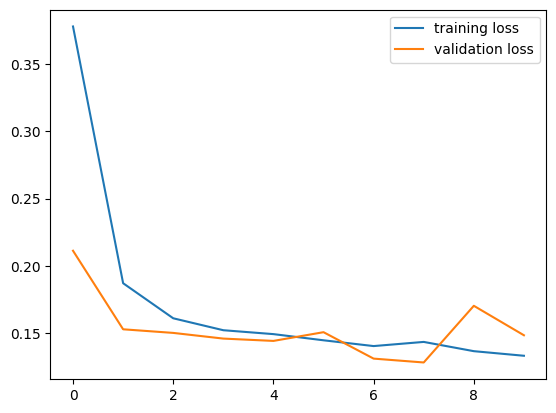

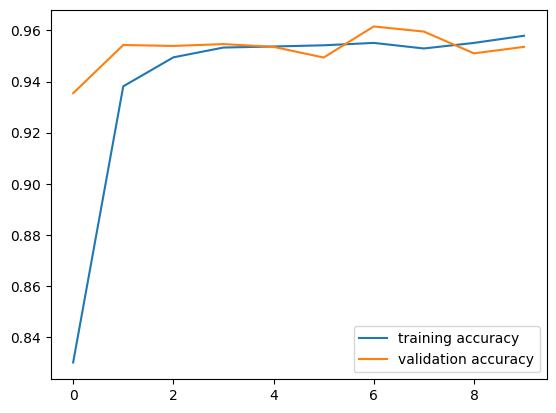

In [58]:
#Model performance plot

#plotting the losses
plt.plot(r.history['loss'], label='training loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.savefig('model_performances_plots/Custom_CNN_loss')
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='training accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.savefig('model_performances_plots/Custom_CNN_Accuracy')
plt.show()

<h2>Model Evaluation with Test Dataset<h2>

In [5]:
#loading test dataset
test_dataset = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path,
                                                 target_size = (IMAGE_LENGTH, IMAGE_BREADTH),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

Found 2756 images belonging to 2 classes.


In [5]:
#loading the model
from tensorflow.keras.models import load_model
loaded_model = load_model(os.path.join('saved_models','custom_CNN.h5'))

In [62]:
#Importing and initializing metrics
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

In [63]:
accuracy = BinaryAccuracy()
precision = Precision()
recall = Recall()
tp = TruePositives()
tn = TrueNegatives()
fp = FalsePositives()
fn = FalseNegatives()

In [64]:
#Iterating over test dataset and updating metrics, structure[infected,uninfected]
i = 1
for batch in test_dataset:
    print("starting batch",i)
    images, y = batch
    #plt.imshow(images[0])
    yhat = loaded_model.predict(images)
    y=y[: , :1]
    yhat=yhat[: , :1]
    #print(y)
    #print(yhat)
    accuracy.update_state(y, yhat)
    precision.update_state(y, yhat)
    tp.update_state(y, yhat)
    tn.update_state(y, yhat)
    fp.update_state(y, yhat)
    fn.update_state(y, yhat)
    recall.update_state(y, yhat)
    print('completed bacth',i)
    i = i+1
    if i>math.ceil(2756/BATCH_SIZE):
        break

starting batch 1
completed bacth 1
starting batch 2
completed bacth 2
starting batch 3
completed bacth 3
starting batch 4
completed bacth 4
starting batch 5
completed bacth 5
starting batch 6
completed bacth 6
starting batch 7
completed bacth 7
starting batch 8
completed bacth 8
starting batch 9
completed bacth 9
starting batch 10
completed bacth 10
starting batch 11
completed bacth 11
starting batch 12
completed bacth 12
starting batch 13
completed bacth 13
starting batch 14
completed bacth 14
starting batch 15
completed bacth 15
starting batch 16
completed bacth 16
starting batch 17
completed bacth 17
starting batch 18
completed bacth 18
starting batch 19
completed bacth 19
starting batch 20
completed bacth 20
starting batch 21
completed bacth 21
starting batch 22
completed bacth 22
starting batch 23
completed bacth 23
starting batch 24
completed bacth 24
starting batch 25
completed bacth 25
starting batch 26
completed bacth 26
starting batch 27
completed bacth 27
starting batch 28
c

In [65]:
print("accuracy =",accuracy.result().numpy(),", precision =", precision.result().numpy(),", recall =", recall.result().numpy())
print("true positives =",tp.result().numpy(),", true negatives =",tn.result().numpy(),", false positives =",fp.result().numpy(),"false negatives =",fn.result().numpy())

accuracy = 0.96081275 , precision = 0.97888386 , recall = 0.94194484
true positives = 1298.0 , true negatives = 1350.0 , false positives = 28.0 false negatives = 80.0


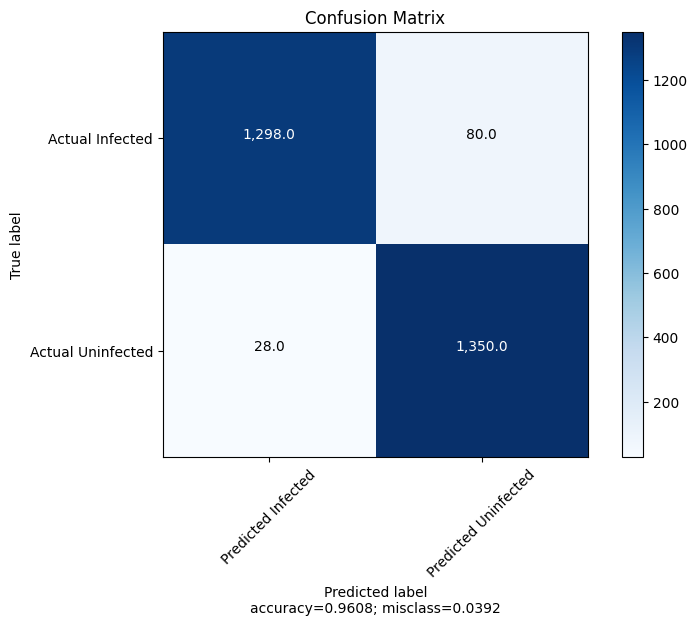

In [67]:
#plotting confusion matrix
#citation: https://www.kaggle.com/code/grfiv4/plot-a-confusion-matrix
import itertools

cm =  np.array([[ tp.result().numpy(),  fn.result().numpy()],
                [  fp.result().numpy(),  tn.result().numpy()]])
normalize = False
cmap = None

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

if cmap is None:
    cmap = plt.get_cmap('Blues')

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(2)
plt.yticks(tick_marks, ["Actual Infected","Actual Uninfected"])
plt.xticks(tick_marks, ["Predicted Infected","Predicted Uninfected"], rotation=45)

thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('confusion_matrices/custom_CNN_CM')
plt.show()

<h2>Predicting Single Image<h2>

[[0.9621376  0.03786249]]
Parasitized


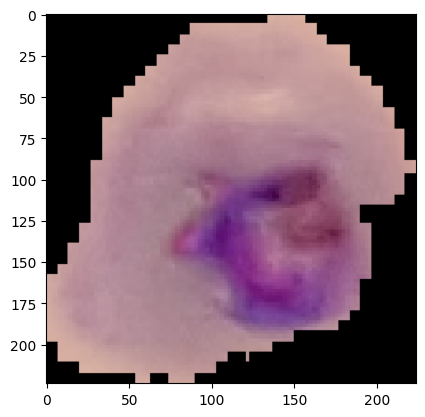

In [39]:
#loading single image from a specific path
from tensorflow.keras.preprocessing import image

img_path='Dataset/cell_images/Parasitized/C39P4thinF_original_IMG_20150622_105102_cell_83.png'
img=image.load_img(img_path,target_size=(224,224))
img=image.img_to_array(img)/255
img=np.expand_dims(img,axis=0)
y=loaded_model.predict(img)
print(y)
plt.imshow(image.load_img(img_path,target_size=(224,224)))

a=np.argmax(y, axis=1)
if(a==1): print("Uninfected")
else: print("Parasitized")

[[1. 0.]]
[[9.999995e-01 5.296819e-07]]


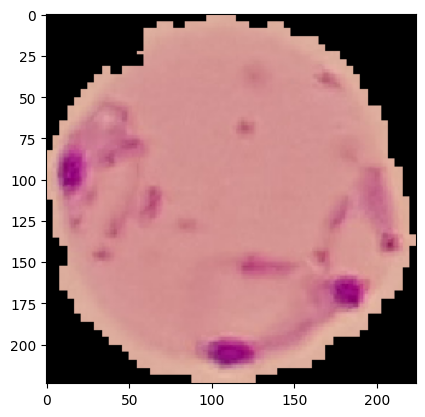

In [21]:
#predicting single image using ImageDatagenerator
i=1
images, y = test_dataset[0]
print(y[i:i+1])
plt.imshow(images[i])
yhat = loaded_model.predict(images[i:i+1])
print(yhat)